In [1]:
# It would be nice to see if the rolling cadence splits the seasons or do we get full seasons
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
dbFile = 'rolling_mix_10yrs_opsim.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []

metric = metrics.PassMetric(cols=['observationStartMJD', 'filter', 'fiveSigmaDepth', 'night'])
#slicer = slicers.UserPointsSlicer(ra=120., dec=-60.)
slicer = slicers.UserPointsSlicer(ra=[0., 120], dec=[-60., -60])

sql = ''

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'night', 'fieldRA', 'filter', 'fiveSigmaDepth', 'fieldDec'].
Found 2203533 visits
Running:  ['opsim_Pass_observationStartMJD_filter_fiveSigmaDepth_night_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
filter2color = {'u': 'purple', 'g': 'blue', 'r': 'green', 'i': 'cyan', 'z': 'orange', 'y': 'red'}
bundleList[0].metricValues[0].dtype

dtype((numpy.record, [('observationStartMJD', '<f8'), ('night', '<i8'), ('fieldRA', '<f8'), ('filter', '<U256'), ('fiveSigmaDepth', '<f8'), ('fieldDec', '<f8')]))

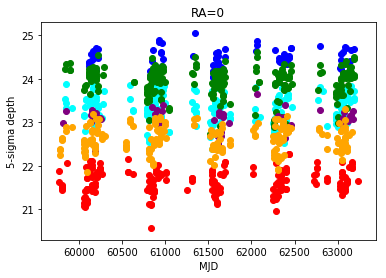

In [6]:
u_filters = np.unique(bundleList[0].metricValues[0]['filter'])
for filtername in u_filters:
    good = np.where(bundleList[0].metricValues[0]['filter'] == filtername)
    plt.scatter(bundleList[0].metricValues[0]['observationStartMJD'][good], 
               bundleList[0].metricValues[0]['fiveSigmaDepth'][good],
               c=filter2color[filtername])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth')
plt.title('RA=%i' % np.degrees(slicer.slicePoints['ra'][0]))

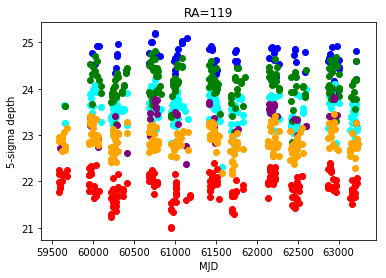

In [7]:
for filtername in u_filters:
    good = np.where(bundleList[0].metricValues[1]['filter'] == filtername)
    plt.scatter(bundleList[0].metricValues[1]['observationStartMJD'][good], 
               bundleList[0].metricValues[1]['fiveSigmaDepth'][good],
               c=filter2color[filtername])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth')
plt.title('RA=%i' % np.degrees(slicer.slicePoints['ra'][1]))

In [8]:
bundleList[0].metricValues[0].size

937

In [9]:
# Hmm, ok, so it looks like the spot at ra=120, dec = -60 doesn't roll that much. 


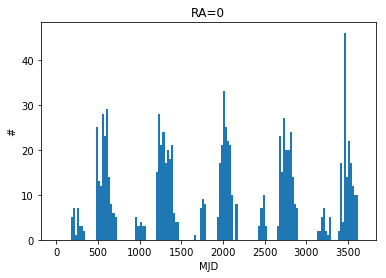

In [10]:
bins = np.arange(0,365*10+25, 25)
ack = plt.hist(bundleList[0].metricValues[0]['night'], bins=bins)
plt.xlabel('MJD')
plt.ylabel('#')
plt.title('RA=%i' % np.degrees(slicer.slicePoints['ra'][0]))

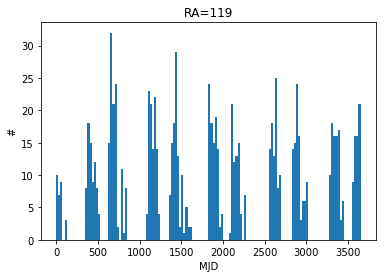

In [11]:
bins = np.arange(0,365*10+25, 25)
ack = plt.hist(bundleList[0].metricValues[1]['night'], bins=bins)
plt.xlabel('MJD')
plt.ylabel('#')
plt.title('RA=%i' % np.degrees(slicer.slicePoints['ra'][1]))

In [12]:
# So, things that are on the meridian at midnight can be considered as "mid season". Meridian at sunset are "end of season", meridian at sunrise "start of season".
# So I could have a feature that tracks which "season" number a point on the sky is in. Then the target maps are set not by year but by season.
